# Building the theory


Testing scalablity means to measure how a program deals with an increasing number of cores and problem size. A perfectly scalable problem would divide computational work perfectly among available resources. We measure this property by calculating how much time a program takes until completion. 

In this context, we will formalize a program as a function that takes two values, $c$ the number of cores and $s$ the problem size, and maps to a completion time:

$$
P(c,s): \mathbb{R}^2 \to \mathbb{R}
$$

Following the idea of big-O notation, this function can be approximated as 

$$
P(c,s) \approx \cfrac{\alpha s^n}{c} + N
$$

Where:

- $\alpha$ is real positive number.
- $s$ is the problem size, a real positive number. 
- $n$ the biggest exponent of the polynomial. 
- $c$ the number of cores. 
- $N$ additive gaussian white noise. 

In any case, scalability will be measure with the composite function $F(c): \mathbb{R} \to \mathbb{R}$

$$
F(c) = \left.\cfrac{P(c_i, s)}{P(c, s)}\right\rvert_{s=G(c)}
$$

Let analyze this expresion. First, in the denominator, $c$ takes a constant value of $c_i$, commonly $c_i = 1$. This means that we will compare how much time a program with $c$ cores takes againts the same program running with only $c_i$ cores. Second, $s$ takes the value $G(c)$, a function that maps a number of cores to an appropiate problem size, this will make sense in the *weak scalability* section. 

## A *mental* experiment 

This is classic example. Suppose you have to build a wall, composed of two thousand bricks. You add a new brick to the wall every thirty seconds, so, building The Wall will takes you $\sim 16.6$ h (It takes more, according to R. Waters, 1979). But what happens if you get *a little help from your friends* (McCartney, Lenon.1967)? Suppose only one friend is willingly to help you, she adds a new brick to the wall at the same rate than you. So, you will end in $\sim 8.3$ h. With four friends it takes $\sim 4.16$h; $\sim 2.08$ h with eight friends; $\sim 1.04$ h with sixteen friends. Do you see the pattern? Where does it come from? 

Let write the *P* function for this problem. $a$ is the rate at which a worker adds a new brick to the wall. $s$ is the number of bricks, and this problem grows linearly, so $n=1$. For simplicity, just drop out the $N$ element. 

$$
P(c, 2000) = \cfrac{30 \cdot 2000}{c}
$$

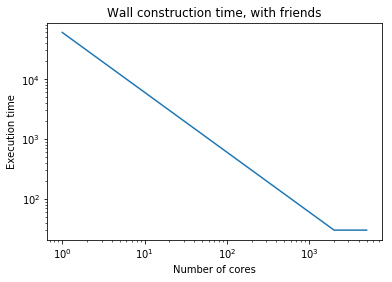

In [17]:
import matplotlib.pyplot as plt 

a = 30
s = 2000
P = lambda c:  a * s / c if c <= s else a * s / 2000

cores = range(1, 5000)
time = [P(c) for c in cores]
plt.loglog(cores, time)
plt.title('Wall construction time, with friends')
plt.xlabel('Number of cores')
plt.ylabel('Execution time')
plt.show()

The image shows that execution time is inversely proportional to the number of cores, until $c=2000$. Just think about it, if there's only 2000 bricks and you have 1999 friends, every friend kindly adds a brick to the wall and that's it! The wall is ready in 30s. Any other friend beyond that 2000 workers limit would be idle. So, is that everyting? Just add a lot of cores to solve everything fast? 

Not really. This kind of problems (called *embarranssingly parallel*), in which every worker is completely independent, are the only ones that can scale that easy with the number of cores. Even so, there are some limits. Unless your wall heights one brick only, some friends have to build the first line of bricks before the others can make their contribution, in the while, the rest is idle. Moreover, it requires some kind of communication to organize all your friends (remember, they are thousands). Therefore, no, the majority of problems will have some kind of *natural* limit on how many cores you can add until it stops making sense. If you end up with 10 000 friends, the effort required to organize the group will make last as having only one thousand friends. 

Let say that every friend adds a little of complication, so the rate at which a new brick is added to the wall is lower:

$$
P(c) = \cfrac{(30 + 0.1 c) \cdot 2000}{c}
$$

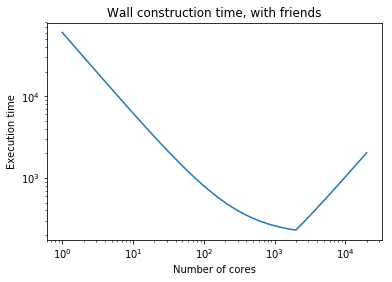

In [34]:
P = lambda c:  (a + 0.1*c) * s / min(c, 2000)

cores = range(1, 20000)
time = [P(c) for c in cores]
plt.loglog(cores, time)
plt.title('Wall construction time, with friends')
plt.xlabel('Number of cores')
plt.ylabel('Execution time')
plt.show()

Those curves are known as U-shapes, and parallel programs use to show that behavior. The whole point of testing scalability is characterizing the application in orden to find the lower point of that U-shape.

## Strong scaling 


For this test, we will set $s = G(c)$ to a constant value. So, we will test how well the application divides the work among the cores. Following with the wall's example:

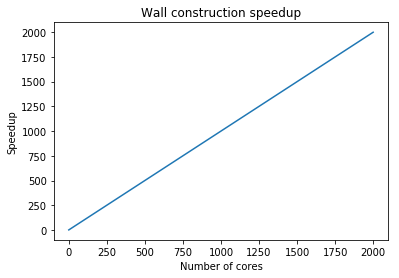

In [45]:
a = 30
P = lambda c,s: a*s/c 

s = 2000
F = lambda c: P(1, s)/P(c, s)

cores = range(1, 2000)
speedup_ideal = [F(c) for c in cores]
plt.plot(cores, speedup_ideal)
plt.title('Wall construction speedup')
plt.xlabel('Number of cores')
plt.ylabel('Speedup')
plt.show()


The figure above shows ideal behavior. In reality, one would expect a penalty for administrating a huge number of cores and finding some practical limit to how much a problem can be splitted. 

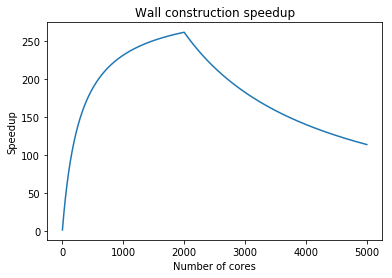

In [46]:
P = lambda c, s: (a + 0.1*c) * s / min(c, s)

cores = range(1, 5000)
speedup_real = [F(c) for c in cores]
plt.plot(cores, speedup_real)
plt.title('Wall construction speedup')
plt.xlabel('Number of cores')
plt.ylabel('Speedup')
plt.show()


Commonly, U-shapes don't have that spiky point, that's a defect of the simple matematical model we are using. But it captures the relevant behavior. 

## Weak scaling

This test will stress the application by giving it more cores, but at the same time increasing problem size proportionaly, therefore, the work per core stays steady. 

To understand what *proportionally* means, look at the $P$ function. With a given problem size $s_0$ and number of cores $c_0$, a program takes $k_0$ units of time until completion

$$
k_0 = P(c_0, s_0) = \cfrac{s_0^n}{c_0}
$$

At iteration $i$, the program takes $k_i$ units of time until completion

$$
k_i = P(c_i, s_i) = \cfrac{s_i^n}{c_i}
$$

If the condition that problem size grows proportionally to the number of cores, it must be true that $k_0 = k_i$, then:

$$
\cfrac{s_0^n}{c_0} = \cfrac{s_i^n}{c_i}
\implies s_i = s_0 \sqrt[n]{\cfrac{c_i}{c_0}}
$$

Commonly, the growth function $G(c)$, presented somewhat misteriously at the begining, takes exactly that form:

$$
G(c) = s_0 \sqrt[n]{\cfrac{c}{c_0}}
$$

But the user can add factors to better approximate the growth rate of the application. Lets test this with the wall example:

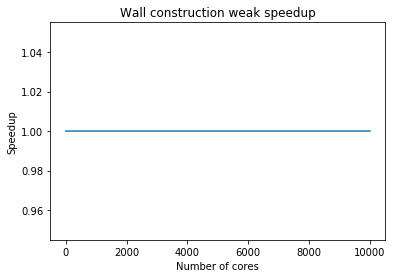

In [56]:
# size grows linearly, so n = 1

s_0 = 2000
c_0 = 1
a = 30

G = lambda c: s_0 * c / c_0
P = lambda c, s: a * s(c) / c
F = lambda c: P(1, G)/P(c, G)


cores = range(c_0, 10000)
w_speedup_ideal = [F(c) for  c in cores]
plt.plot(cores, w_speedup_ideal)
plt.title('Wall construction weak speedup')
plt.xlabel('Number of cores')
plt.ylabel('Speedup')
plt.show()


As expected, if the problem size keeps with the number of cores, every iteration takes the same time. What happens with a more realistic scenario in which managing more cores imposes a penalty over the application:

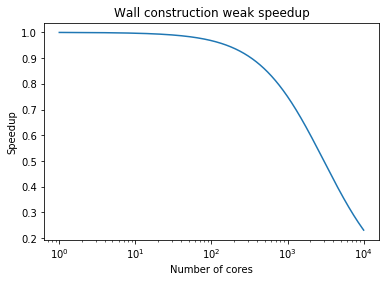

In [64]:
P = lambda c, s: (a + 0.01*c) * s(c) / s(c)

cores = range(c_0, 10000)
w_speedup_real = [F(c) for  c in cores]
plt.semilogx(cores, w_speedup_real)
plt.title('Wall construction weak speedup')
plt.xlabel('Number of cores')
plt.ylabel('Speedup')
plt.show()


Notice how even an small penalty of $0.01$ per core rapidly degradates performances as the number of cores grows big enough. Launching a parallel application with the right parameters means balancing two opposite behaviors:

- Speedup provided by the increase in number of cores 
- Slowdown provided by the penalty of managing and communicating a big number of cores.